In [1]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords 
import re
from nltk.stem import PorterStemmer
from collections import Counter

In [2]:
df = pd.read_csv('corpus.csv')
df.head()

,Abstract,Index Keywords,Title
0,Building scientists have retraced the origins ...,Environmental design; Feedback; History; Human...,The House of Commons: a precedent for post-occ...
1,Governmental and local authorities are facing ...,Big data; Cloud computing; Data handling; Digi...,Developing a government enterprise architectur...
2,Gamification is increasingly used as an essent...,Computer networks; Information management; Soc...,Does gamification satisfy needs? A study on th...
3,With the progressive scale-down of semiconduct...,Calculations; Computer programming; DNA; Subst...,DNA computing for combinational logic
4,In order to obtain high-quality superconductin...,Electron beam lithography; Electron beams; Fab...,Fabrication of Al/AlOx/Al Josephson junctions ...


In [3]:
len(df)

2016

In [4]:
#Helper Functions
def preprocess_w2vec(string):
    # Returns list of word-tokenized sentences
    string = string.lower()
    data = sent_tokenize(string)
    for i in range(len(data)):
        data[i] = re.sub(r'\W+', ' ', data[i])  #Remove non alphanumeric character
        data[i] = word_tokenize(data[i])
    stop_word = set(stopwords.words('english'))
    res = []
    ps = PorterStemmer()
    for i in range(len(data)):
        tmp = []
        for j in range(len(data[i])):
            if data[i][j] not in stop_word:
                data[i][j] = ps.stem(data[i][j])
                tmp.append(data[i][j])
        res.append(tmp)
    return res

def preprocess_LDA(string):
    # Returns list of word-tokenized sentences
    string = string.lower()
    data = sent_tokenize(string)
    for i in range(len(data)):
        data[i] = re.sub(r'\W+', ' ', data[i])  #Remove non alphanumeric character
        data[i] = word_tokenize(data[i])
    stop_word = set(stopwords.words('english'))
    res = []
    ps = PorterStemmer()
    for i in range(len(data)):
        tmp = []
        for j in range(len(data[i])):
            if data[i][j] not in stop_word:
                data[i][j] = ps.stem(data[i][j])
                tmp.append(data[i][j])
        res.append(tmp)
    out = ' '.join(str(item) for innerlist in res for item in innerlist)
    return out

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            #topic_words.append(the_word.encode('ascii').decode('utf-8'))
            topic_words.append(the_word)
        top_words.append(" ".join(topic_words))      
    return top_words

In [5]:
sentences = []
for i in range(len(df)):
    string = df['Title'][i]
    res = preprocess_w2vec(string)
    tmp = []
    for j in range(len(res)):
        sentences.append(res[j])
        for k in range(len(res[j])):
            tmp.append(res[j][k])

In [6]:
from gensim.models import Word2Vec
model = Word2Vec(sentences, min_count=1,window=5,size =50)
print(model)

Word2Vec(vocab=4556, size=50, alpha=0.025)


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
text_sample = [preprocess_LDA(text) for text in df['Title']]
count_vectorizer = CountVectorizer(max_features=10000)

document_term_matrix = count_vectorizer.fit_transform(text_sample)

from sklearn.decomposition import LatentDirichletAllocation
n_topics = 5
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(document_term_matrix)
lda_topic_matrix.shape

(2016, 5)

In [8]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

top_n_words_lda = get_top_n_words(10, lda_keys, document_term_matrix, count_vectorizer)

print('Topics when using only LDA:')
for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topics when using only LDA:
Topic 1:  base comput algorithm system model analysi learn scienc method studi
Topic 2:  base network use data system analysi model comput approach learn
Topic 3:  comput scienc system applic 2018 confer inform intern practic framework
Topic 4:  use system base quantum model simul manag technolog robot effici
Topic 5:  use base design comput model method studi simul evalu system


In [9]:
#Top 2 words
w2vec_lda = []
for i in range(len(top_n_words_lda)):
    lis = []
    lis.append((top_n_words_lda[i].split()[0],1.0))
    tmp = model.most_similar(top_n_words_lda[i].split()[0])[:4]
    for j in range(len(tmp)):
        lis.append(tmp[j])
    lis.append((top_n_words_lda[i].split()[0],1.0))
    tmp = model.most_similar(top_n_words_lda[i].split()[1])[:4]
    for j in range(len(tmp)):
        lis.append(tmp[j])
    w2vec_lda.append(lis)
print('Topics when using LDA and Word2vec:')      
for i in range(len(top_n_words_lda)):
    print("Topic {}:\n ".format(i+1), w2vec_lda[i])

Topics when using LDA and Word2vec:
Topic 1:
  [('base', 1.0), ('use', 0.9366466403007507), ('model', 0.9069707989692688), ('applic', 0.905810534954071), ('network', 0.890936017036438), ('base', 1.0), ('inform', 0.886013388633728), ('model', 0.8774790167808533), ('base', 0.8734726905822754), ('analysi', 0.8657522797584534)]
Topic 2:
  [('base', 1.0), ('use', 0.9366466403007507), ('model', 0.9069707989692688), ('applic', 0.905810534954071), ('network', 0.890936017036438), ('base', 1.0), ('base', 0.890936017036438), ('technolog', 0.8722935318946838), ('use', 0.8627199530601501), ('analysi', 0.8594511151313782)]
Topic 3:
  [('comput', 1.0), ('inform', 0.886013388633728), ('model', 0.8774790167808533), ('base', 0.8734726905822754), ('analysi', 0.8657522797584534), ('comput', 1.0), ('use', 0.8748251795768738), ('applic', 0.8390567302703857), ('studi', 0.834876298904419), ('base', 0.8321282863616943)]
Topic 4:
  [('use', 1.0), ('base', 0.936646580696106), ('model', 0.9087986350059509), ('des

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#Usind Word2vec on LDA output
'''w2vec_lda = []
for i in range(len(top_n_words_lda)):
    lis = []
    lis.append((top_n_words_lda[i].split()[0],1.0))
    tmp = model.most_similar(top_n_words_lda[i].split()[0])[:6]
    for j in range(len(tmp)):
        lis.append(tmp[j])
    w2vec_lda.append(lis)
print('Topics when using LDA and Word2vec:')      
for i in range(len(top_n_words_lda)):
    print("Topic {}:\n ".format(i+1), w2vec_lda[i])'''

In [11]:
def topic_assign(string):
    string = string.lower()
    string = re.sub(r'\W+', ' ', string)
    string = word_tokenize(string)
    ps = PorterStemmer()
    string = [ps.stem(w) for w in string]
    #string
    res = np.zeros(n_topics)
    from sklearn.metrics.pairwise import cosine_similarity
    for w in string:
        if w not in model.wv.vocab:
            continue
        sim = np.zeros(n_topics)
        for j in range(len(w2vec_lda)):
            for k in range(len(w2vec_lda[j])):
                sim[j] = sim[j] + cosine_similarity( model.wv[w2vec_lda[j][k][0]].reshape(1,50), model.wv[w].reshape(1,50) )[0][0]*w2vec_lda[j][k][1]
        res[sim.argmax()] = res[sim.argmax()] + 1
    if res[res.argmax()]==0:
        return None
    return res.argmax() + 1
    '''res = sim.argmax()
    if sim[res]==0:
        return None
    else: return res+1'''

In [12]:
#Assigning topics to first 100 entries of dataset
df2 = df[:200]
df2['Topic'] = [topic_assign(string) for string in df2['Title']]
df2

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Abstract,Index Keywords,Title,Topic
0,Building scientists have retraced the origins ...,Environmental design; Feedback; History; Human...,The House of Commons: a precedent for post-occ...,2
1,Governmental and local authorities are facing ...,Big data; Cloud computing; Data handling; Digi...,Developing a government enterprise architectur...,5
2,Gamification is increasingly used as an essent...,Computer networks; Information management; Soc...,Does gamification satisfy needs? A study on th...,1
3,With the progressive scale-down of semiconduct...,Calculations; Computer programming; DNA; Subst...,DNA computing for combinational logic,5
4,In order to obtain high-quality superconductin...,Electron beam lithography; Electron beams; Fab...,Fabrication of Al/AlOx/Al Josephson junctions ...,3
5,Recent advances in fabrication complexity and ...,Clocks; Computer circuits; Integrated circuit ...,Development of an All-SFQ Superconducting Fiel...,2
6,Phyllis Illari and Jon Williamson propose a fo...,NaN,A refinement to the general mechanistic account,1
7,This article discusses dependence on initial c...,Chaos theory; Numerical analysis; Turbulence; ...,Dependence upon initial conditions,5
8,Pseudo-repetitions are a natural generalizatio...,Computer networks; String searching algorithms...,Hide and seek with repetitions,1
9,Parkinson's disease (PD) is a neurodegenerativ...,Automation; Computer aided diagnosis; Convolut...,A recurrence plot-based approach for Parkinson...,2


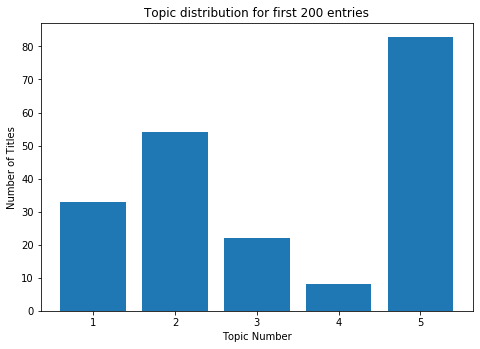

In [14]:
top_dist = np.zeros(n_topics)
for n in df2['Topic']:
    top_dist[n-1] = top_dist[n-1]+1
    
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
top = [1,2,3,4,5]
ax.bar(top,top_dist)
#ax.hist(top_dist)
plt.xlabel('Topic Number')
plt.ylabel('Number of Titles')
plt.title('Topic distribution for first 200 entries')
plt.show()